# Model evaluation utilities

In [ ]:
#| default_exp ml.evaluation

In [ ]:
#| hide
from fastcore.test import *
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from fastcore.basics import ifnone

In [ ]:
#| export
def find_binary_clf_threshold(targets, preds, metrics, *, threshold_range=None, weight=None, metric_names=None, show=True):
    """Find the best threshold for binary classification given targets and predicted probabilities"""
    if weight is None:
        weight = [1.0] * len(metrics)
    if threshold_range is None:
        threshold_range = np.arange(0, 1, 0.05)
    weight = (np.array(weight) / np.sum(weight)).reshape(len(metrics), -1)
    scores = np.array([
        [metric(targets, preds > threshold) for threshold in threshold_range]
        for metric in metrics
    ])
    wavg_scores = (scores * weight).sum(axis=0)
    best_idx = wavg_scores.argmax()
    best_threshold =  threshold_range[best_idx]
    best_score =  wavg_scores[best_idx]

    if show:
        import matplotlib.pyplot as plt
        if metric_names is None:
            metric_names = [None]*len(metrics)
        metric_names = [
            ifnone(name, ifnone(getattr(metric, '__name__', None), f"Metric - {i}")) 
            for i, (metric, name) in enumerate(zip(metrics, metric_names))
        ]
        fig = plt.figure(figsize=(8, 4))
        plt.plot(threshold_range, scores.T, label=metric_names)
        plt.plot(threshold_range, wavg_scores.T, label='Weighted avg', linewidth=2)
        plt.plot([best_threshold], [best_score], 'ro')
        plt.axvline(x=best_threshold, color='gray', linestyle='--')
        plt.legend(loc='best')
        plt.show()
    
    return best_threshold

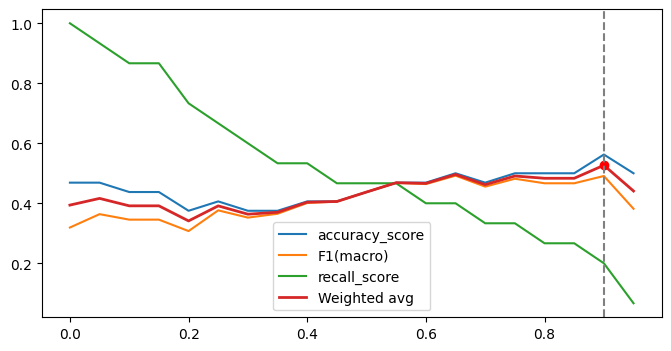

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from functools import partial

f1_macro = partial(f1_score, average='macro')

bs = 32
preds = np.random.rand(bs)
targets = np.random.randint(0, 2, bs)
threshold = find_binary_clf_threshold(
    targets, 
    preds, 
    [accuracy_score, f1_macro, recall_score], 
    weight=[0.5, 0.5, 0], 
    metric_names=[None, 'F1(macro)', None]
)

In [ ]:
#| hide
preds = np.array([0.6, 0.3, 0.5, 0.9, 0.8, 0.2, 0.55, 0.77])
targets = np.array([1,0,0,1,1,0,1,1])
thresh = find_binary_clf_threshold(targets, preds, [accuracy_score], show=False)
test_close(thresh, 0.5)

In [ ]:
#| export
import pandas as pd
from sklearn.metrics import classification_report

def classification_summary(targets, preds, class_names, show=False, figsize=(16, 12)):
    label_indices = list(range(len(class_names)))
    clf_dict = classification_report(
        targets,
        preds,
        labels=label_indices,
        target_names=class_names,
        output_dict=True,
    )
    df = pd.DataFrame.from_records(clf_dict).T
    df = df.loc[class_names + sorted(list(set(df.index.values).difference(class_names)))] 
    if show:
        from sklearn.metrics import ConfusionMatrixDisplay
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(figsize=figsize)
        ConfusionMatrixDisplay.from_predictions(
            targets, 
            preds, 
            labels=label_indices, 
            display_labels=class_names, 
            ax=ax,
        )
    return df

def evaluate_slmc(learn, *, dls=None, dl=None, class_names=None, **kwargs):
    assert not (dls is None and dl is None)
    class_names = ifnone(class_names, dls.vocab)
    dl = ifnone(dl, dls.valid)
    _, targets, preds = learn.get_preds(dl=dl, with_decoded=True)
    return classification_summary(targets.cpu().numpy(), preds.cpu().numpy(), class_names=list(class_names), **kwargs)

In [ ]:
import torch
from unittest.mock import Mock
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from IPython.display import display

n = 128
class_names = ['cat', 'dog', 'fox', 'cow', 'snake']
targets = np.random.randint(0, len(class_names), size=(n, 1))
preds = np.clip(targets + np.random.randint(-2, 2, size=(n, 1)), 0, len(class_names))

dls = Mock()
dls.vocab = class_names
dls.valid = None
learn = Mock()
learn.get_preds.return_value = None, torch.from_numpy(targets), torch.from_numpy(preds)

with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning, module=r'.*')
    clf_df = evaluate_slmc(learn, dls=dls, figsize=(4, 3))
display(clf_df)

test_eq(clf_df.columns.tolist(), ['precision', 'recall', 'f1-score', 'support'])
test_eq(len(set(class_names).difference(clf_df.index.values)), 0)

,precision,recall,f1-score,support
cat,0.543478,0.892857,0.675676,28.0
dog,0.346154,0.264706,0.300000,34.0
fox,0.130435,0.157895,0.142857,19.0
cow,0.555556,0.370370,0.444444,27.0
snake,0.666667,0.300000,0.413793,20.0
macro avg,0.448458,0.397166,0.395354,128.0
micro avg,0.434426,0.414062,0.424000,128.0
weighted avg,0.451549,0.414062,0.407102,128.0


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()